In [55]:
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(scales)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')

paired_positions = c('X1.72'='1:72', 'X2.71'='2:71', 'X3.70'='3:70', 'X4.69'='4:69', 'X5.68'='5:68', 'X6.67'='6:67', 'X7.66'='7:66', 'X8.14'='*8:14', 'X9.23'='*9:23', 'X10.25'='10:25', 'X10.45'='*10:45', 'X11.24'='11:24', 'X12.23'='12:23', 'X13.22'='13:22', 'X15.48'='*15:48','X18.55'='*18:55', 'X19.56'='*19:56', 'X22.46'='*22:46', 'X26.44'='*26:44', 'X27.43'='27:43', 'X28.42'='28:42', 'X29.41'='29:41', 'X30.40'='30:40', 'X31.39'='31:39', 'X49.65'='49:65', 'X50.64'='50:64', 'X51.63'='51:63', 'X52.62'='52:62', 'X53.61'='53:61', 'X54.58'='*54:58')
paired_identities = c('GC', 'AU', 'UA', 'CG', 'GU', 'UG', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'AminoKeto', 'KetoAmino', 'Wobble', 'Paired', 'Bulge', 'Mismatched', 'Absent')

single_positions = c('X8'='8', 'X9'='9', 'X14'='14', 'X15'='15', 'X16'='16', 'X17'='17', 'X17a'='17a', 'X17b'='17b', 'X18'='18', 'X19'='19', 'X20'='20', 'X20a'='20a', 'X20b'='20b', 'X21'='21', 'X26'='26', 'X32'='32', 'X33'='33', 'X34'='34', 'X35'='35', 'X36'='36', 'X37'='37', 'X38'='38', 'X44'='44', 'X45'='45', 'X46'='46', 'X47'='47', 'X48'='48', 'X54'='54', 'X55'='55', 'X56'='56', 'X57'='57', 'X58'='58', 'X59'='59', 'X60'='60', 'X73'='73')
single_identities = c('A', 'C', 'G', 'U', 'Purine', 'Pyrimidine', 'Weak', 'Strong', 'Amino', 'Keto', 'B', 'D', 'H', 'V', 'Absent')

colors = c('A'='gray20', 'C'='gray20', 'G'='gray20', 'U'='gray20', 'Absent'='gray20', 'Purine'='gray20', 'Pyrimidine'='gray20', 'Weak'='gray20', 'Strong'='gray20', 'Amino'='gray20', 'Keto'='gray20', 'B'='gray50', 'D'='gray50', 'H'='gray50', 'V'='gray50', 'GC'='gray20', 'AU'='gray20', 'UA'='gray20', 'CG'='gray20', 'GU'='gray20', 'UG'='gray20', 'PurinePyrimidine'='gray20', 'PyrimidinePurine'='gray20', 'StrongPair'='gray20', 'WeakPair'='gray20', 'AminoKeto'='gray20', 'KetoAmino'='gray20', 'Wobble'='gray20', 'Paired'='gray20', 'Bulge'='gray20', 'Mismatched'='gray20')
fills = c('A'='#ffd92f', 'C'='#4daf4a', 'G'='#e41a1c', 'U'='#377eb8', 'Purine'='#ff8300', 'Pyrimidine'='#66c2a5', 'Weak'='#b3de69', 'Strong'='#fb72b2', 'Amino'='#c1764a', 'Keto'='#b26cbd', 'B'='#e5c494', 'D'='#ccebd5', 'H'='#ffa79d', 'V'='#a6cdea', 'Absent'='gray60', 'Mismatched'='gray30', 'Paired'='#ffffcc')

suppressMessages(library(Biostrings))

In [2]:
load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('isotype-specific.RData')
load('consensus-IDEs.RData')
load('clade-isotype-specific-freqs.RData')

In [3]:
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
identities = identities %>% mutate(quality=quality & !restrict)

In [4]:
genome_table = read.delim('genome_table+.txt', sep='\t', stringsAsFactors=FALSE, header=FALSE, col.names=c("species_short", "species", "species_long", "domain", "clade"))

# Introduction

Previous analysis in `euk-tRNAs` and `isotype-clade-specific` focused on processing and dicing the data with appropriate assumptions. Now, we move on to the meat of this project. Comparison with previously determined identity elements is tracked in a spreadsheet; the rest is here.

For **new identity stories**, I'll employ a few strategies to find interesting stores in a systematic way. Some of these will have been covered in `first-pass-consensus`.

1. Find rejected sequence features. Set a cutoff at 95% presence, but fails (i) isotype check, (ii) clade check, or (iii) species check. Spin in previous work, if any. Bonus points if previous work _conflicts_ with our frequencies.
    a. rejected consensus features
    b. isotype-specific
    c. clade-isotype-specific elements
    
2. Previous work conflicts with "accepted" identity elements. 

Per Todd's advice, I'll take a look at a few in each category and 

For **analyzing weird tRNAs in context of sequence features**, I will go through a list of weird tRNAs, their isotype-specific scores, and where they went wrong.

# New identity stories

## Strategy 1A

### Find targets

In [6]:
code_groups = c('A'=1, 'C'=1, 'G'=1, 'U'=1, 'Absent'=1, 
                'Purine'=2, 'Pyrimidine'=2,
                'Weak'=3, 'Strong'=3, 'Amino'=3, 'Keto'=3,
                'B'=4, 'D'=4, 'H'=4, 'V'=4,
                'GC'=1, 'AU'=1, 'UA'=1, 'CG'=1, 'GU'=1, 'UG'=1,
                'StrongPair'=2, 'WeakPair'=2, 'Wobble'=2,
                'PurinePyrimidine'=3, 'PyrimidinePurine'=3, 'AminoKeto'=3, 'KetoAmino'=3,
                'Paired'=4, 'Mismatched'=4, 'Bulge'=4)

cutoff_freqs = data.frame()
for (cutoff in c(0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0)) {
  df = clade_iso_ac_freqs %>%
    group_by(positions, variable) %>%
    summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
    filter(freq >= cutoff) %>%
    mutate(cutoff=as.character(cutoff)) %>%
    select(positions, variable, freq, cutoff) %>%
    group_by(positions) %>%
    arrange(code_groups[variable], desc(freq)) %>%
    filter(row_number(positions) == 1)
  if (nrow(cutoff_freqs) == 0) cutoff_freqs = df
  else cutoff_freqs = rbind(cutoff_freqs, df)
}

In [7]:
cutoff_freqs %>% 
  filter(positions %in% c(names(single_positions), names(paired_positions))) %>%
  select(positions, cutoff, variable) %>%
  spread(cutoff, variable)

,positions,0.5,0.6,0.7,0.8,0.9,0.95,0.99
1,X10.25,GC,GC,GC,Paired,Paired,Paired,Paired
2,X11.24,CG,CG,PyrimidinePurine,PyrimidinePurine,PyrimidinePurine,PyrimidinePurine,Paired
3,X12.23,PyrimidinePurine,PyrimidinePurine,Paired,Paired,Paired,Paired,NA
4,X13.22,PyrimidinePurine,Paired,NA,NA,NA,NA,NA
5,X14,A,A,A,A,A,A,A
6,X15,G,G,G,Purine,Purine,Purine,Purine
7,X15.48,GC,GC,GC,PurinePyrimidine,PurinePyrimidine,Paired,NA
8,X16,U,U,U,Pyrimidine,Pyrimidine,B,NA
9,X17,Absent,Absent,Absent,NA,NA,NA,NA
10,X1.72,GC,GC,GC,GC,Paired,Paired,NA


In [9]:
consensus

,positions,identity
1,X10.25,Paired
2,X11.24,Paired
3,X14,A
4,X15,V
5,X1.72,Paired
6,X18,V
7,X19,G
8,X19.56,GC
9,X21,H
10,X2.71,Paired


For strategy 1A, some good candidates here: 
- R9 (95%)
- Y11:R24 (99%)
- G18, U55, and G18:U55 (99%)
- G19:C56 (99%)
- A21 and A14/A21 (99%)
- U33 (99%)
- R37 (99%)
- R46 (99%)
- G53:C61 (99%)
- U54:A58 (99%)
- U55 (99%)
- R57 (99%)
- Y60 (95%)

### R9 and R46

#### What's known

- Marck and Grosjean have a purine for iMet and no consensus for elongator, though they are mostly R or V. R9 is also conserved in initiators for archaea/bacteria.
- 9-12-23 is a tertiary interaction. [Gautheret et al. (1995)](http://dx.doi.org/10.1006/jmbi.1995.0200) has these frequencies from the Sprinzl 1991 database: ![9-12-23 frequency matrix](figures/9-12-23-gautheret.png)

- Position 9 is known to be modified with m$^1$G (along with 37) in a wide range of eukaryotes. 

#### Our data

- Here's our frequencies:

In [10]:
table(paste0(identities[identities$quality, ]$X12, ':', identities[identities$quality, ]$X23), identities[identities$quality, ]$X9)

     
         -    A    C    G    R    U
  A:A    0    5    1    7    0    0
  A:C    0   25    2  227    0    0
  A:G    0    2    1   14    0    0
  A:U    0  492  146   65    0    4
  C:-    0    0    0    1    0    0
  C:A    0    8    0   57    0    1
  C:C    0    1    0    4    0    0
  C:G    0  251   58 6990    0   53
  C:U    0    0    0    6    0    0
  G:A    0    2    0    2    0    0
  G:C    1 1709    7 4182    0    5
  G:G    0    0    0    8    0    0
  G:U    0   14    1   31    0    0
  U:A    0 6571    6 1842    1   33
  U:C    0    2    0    2    0    0
  U:G    0   23    0   68    0    0
  U:U    0    5    0    1    0    0

**Which isotypes/clades/species fail the consensus checks?**

In [11]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X9') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable %in% c("G", "A", "Purine"))*count)/sum(count) == 1) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, X9) %>% group_by(clade, species, isotype) %>%
  summarize(status=sum(X9 %in% c("G", "A", "Purine")/n()) >= 0.1,
            freq=sum(X9 %in% c("G", "A", "Purine")), ntRNAs=n()) %>%
  filter(!status)

,clade,isotype,status
1,Insecta,Glu,FALSE
2,Insecta,His,FALSE
3,Mammalia,His,FALSE
4,Vertebrata,His,FALSE


,clade,species,isotype,status,freq,ntRNAs
1,Fungi,crypGatt_WM276,Gly,FALSE,0,2
2,Fungi,crypNeof_VAR_GRUBII_H99,Gly,FALSE,0,2
3,Fungi,crypNeof_VAR_NEOFORMANS_B_3501,Gly,FALSE,0,2
4,Fungi,crypNeof_VAR_NEOFORMANS_JEC21,Gly,FALSE,0,2
5,Insecta,dm6,His,FALSE,0,5
6,Insecta,dp4,His,FALSE,0,5
7,Insecta,dp4_Unknown_group_638.trna1-GluCTC,Glu,FALSE,0,1
8,Insecta,dp4_Unknown_group_638.trna2-GluCTC,Glu,FALSE,0,1
9,Insecta,droAna3,His,FALSE,0,5
10,Insecta,droEre2,His,FALSE,0,6


#### What's new

The 9:12:23 ratios are a bit different. But it shows the same thing: there is some selectivity for what base triples are allowed, but enough tolerance that there are a few interactions that persist.

The default hypothesis is that the 9-23 interaction has a conserved interaction type that explains the frequencies shown. We can marginalize as such because 12:23 is always a WC pair. This is not the case - although some (R:R) have a a strong trans WC-Hoogsteen pair of hydrogen bonds, others (C:R) do not. The hoogsteen side of C is just two stable carbons unlikely to hydrogen bond.

Examining the frequencies _without_ histidine shows that the C9:U23 is conserved in His, and A9:U23 is conserved in Asp, for some clades. (See tertiary interactions figure).

In [12]:
table(identities[identities$quality, ]$X9, identities[identities$quality, ]$X23)

   
       -    A    C    G    U
  -    0    0    1    0    0
  A    0 6586 1737  276  511
  C    0    7    9   59  147
  G    1 1908 4415 7080  103
  R    0    1    0    0    0
  U    0   34    5   53    4

So here's what we know.
- 12:23 is almost always WC paired, so we can marginalize it.
- 9 is typically a purine, though there are isotype- and clade-specific exceptions. For example, His and Asp deviate in 4 clades.
    - In the His case, C and U can interact via the 2-carbonyl [amino pairing](http://www.columbuslabs.org/wp-content/uploads/2008/03/basepairs.pdf).
- 9:23 is thought to be a _trans_ interaction with two hydrogen bonds.

**Conclusion 1**: Position 9 was thought to be a purine. Instead, it varies by isotype and clade. Much of the variation from R9 can be explained by looking at 9:23 as an clade/isotype discriminating tertiary interaction.

We can leave it at that. But we should also look into compensatory interactions if 9:23 is disrupted.

### Covariation for core D stem 3d pairs

#### tRNA covariation frequencies for 9:23, 22:46, and 10:45

In [13]:
df = table(paste0(identities[identities$quality, ]$X9, ':', identities[identities$quality, ]$X23),
           paste0(identities[identities$quality, ]$X46, ':', identities[identities$quality, ]$X22, ' / ', identities[identities$quality, ]$X45, ':', identities[identities$quality, ]$X10),
           identities[identities$quality, ]$isotype)

In [14]:
as.data.frame(df) %>% group_by(Var3) %>% filter(Freq > 50)

,Var1,Var2,Var3,Freq
1,A:A,G:G / G:G,Ala,1382
2,G:C,G:G / G:G,Ala,120
3,G:A,G:U / G:G,Ala,51
4,G:C,A:A / G:G,Arg,318
5,G:G,A:A / G:G,Arg,954
6,G:G,A:C / G:G,Arg,60
7,G:C,G:G / G:G,Arg,449
8,G:G,A:A / G:G,Asn,86
9,A:A,G:G / G:G,Asn,108
10,G:C,G:G / G:G,Asn,457


This is messy. For each isotype there may be a different tertiary interaction compensating for the lack of A:A. It seems that purine:purine interactions are unusually enriched among all three of these except in valine. 

![classical interaction structure](figures/3d-interactions-oliva.png)

#### Average number of purine:purine interactions by isotype and clade

In [15]:
RRs = c("A:A", "A:G", "G:G", "G:A")
identities %>% select(isotype, clade, quality, X9.23, X22.46, X10.45, X26.44) %>% 
  filter(quality) %>%
  rowwise() %>% 
  mutate(nRR=(X9.23 %in% RRs) + (X22.46 %in% RRs) + (X10.45 %in% RRs) + (X26.44 %in% RRs)) %>%
  group_by(isotype, clade) %>% 
  summarize(nRR=signif(mean(nRR), 3)) %>%
  spread(isotype, nRR)

Warning message:
: Grouping rowwise data frame strips rowwise nature

,clade,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,iMet,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,Fungi,2.9,3.23,3.56,3.18,3.02,1.35,1.88,1.99,2.87,3.45,2.32,1.97,3.44,3.88,3.88,2.02,1.84,3.86,3.02,3.69,2.33
2,Insecta,4,3.62,3,2,4,2,3.29,2.5,2.07,3.57,3,2,4,3,3.94,2.05,1.99,3.97,2.96,4,1.99
3,Mammalia,3.95,3.54,2.95,2.11,3.97,1.97,2.96,2.64,2.04,3.49,3,2,3.92,2.99,3.92,2,2.05,3.99,2.98,3.99,2.17
4,Nematoda,3.98,3.59,2.95,2,4,1.94,2.75,2.48,1.95,3.52,3,1.98,2.59,2.94,3.88,2.02,1.99,3.97,2.82,3.96,2
5,Spermatophyta,4,3.51,3.79,2.05,3.84,2.58,3.55,3.04,3,4,3,2,3.03,3.11,4,2,1.12,3.68,3,4,2
6,Streptophyta,3.98,3.45,3.73,1.97,3.6,2.35,3.39,3.25,3,3.99,3,2,3,2.97,3.97,2.06,1.27,3.73,3,3.78,2
7,Vertebrata,3.96,3.45,2.93,2,3.92,1.98,2.96,2.34,1.99,3.63,2.99,1.97,3.94,2.96,3.72,1.99,2.06,3.95,2.99,3.93,1.97


#### Average number of purine:purine interactions by position/isotype

In [16]:
RRs = c("A:A", "A:G", "G:G", "G:A")
identities %>% select(isotype, quality, X9.23, X22.46, X10.45, X26.44) %>% 
  filter(quality) %>%
  rowwise() %>% 
  mutate(X9.23=X9.23 %in% RRs, X22.46=X22.46 %in% RRs, X10.45=X10.45 %in% RRs, X26.44=X26.44 %in% RRs) %>%
  gather(position, RR, X9.23, X22.46, X10.45, X26.44, -isotype, -quality) %>%
  group_by(isotype, position) %>%
  summarize(RR=round(mean(RR), digits=1)) %>%
  spread(isotype, RR)

,position,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,iMet,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,X10.45,1,1,1,1,1,1,0.9,0.9,1,1,0.8,0,0.9,1,0.9,1,0.1,1,1,1,0.9
2,X22.46,0.9,1,1,1,1,0.8,0.9,0.9,0.9,1,1,1,1,1,1,0,0.9,1,1,1,0.1
3,X26.44,1,1,0.9,0.2,0.9,0,0.2,0.1,0.2,0.9,1,0,0.9,1,1,0,0,1,0.8,1,1
4,X9.23,0.9,0.6,0.3,0.2,0.9,0.1,0.8,0.6,0.2,0.7,0,1,1,0.2,1,1,0.9,1,0.2,1,0.1


#### Average number of interactions containing a purine by position/isotype

In [17]:
RRs = c("A:A", "A:G", "G:G", "G:A", "G:C", "C:G", "A:C", "C:A", "U:G", "G:U", "A:U", "U:A")
identities %>% select(isotype, quality, X9.23, X22.46, X10.45, X26.44) %>% 
  filter(quality) %>%
  rowwise() %>% 
  mutate(X9.23=X9.23 %in% RRs, X22.46=X22.46 %in% RRs, X10.45=X10.45 %in% RRs, X26.44=X26.44 %in% RRs) %>%
  gather(position, RR, X9.23, X22.46, X10.45, X26.44, -isotype, -quality) %>%
  group_by(isotype, position) %>%
  summarize(RR=round(mean(RR), digits=1)) %>%
  spread(isotype, RR)

,position,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,iMet,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,X10.45,1,1,1,1,1,1,1,0.9,1,1,1,0,1,1,1,1,0.1,1,1,1,1
2,X22.46,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,X26.44,1,1,1,0.9,1,0.1,0.4,1,0.4,0.9,1,1,1,1,1,1,1,1,1,1,1
4,X9.23,1,1,1,1,1,1,1,1,0.5,1,1,1,1,1,1,1,1,1,1,1,1


#### Are non-purine-containing interactions enriched for some other type of interaction?

In [18]:
identities %>% select(isotype, quality, X9.23, X22.46, X10.45, X26.44) %>% 
  filter(quality) %>%
  gather(position, identity, X9.23, X22.46, X10.45, X26.44, -isotype, -quality) %>%
  filter(!(identity %in% c(RRs, "G:-", "A:-"))) %>%
  group_by(position, isotype, identity) %>%
  summarize(count=n()) %>%
  filter(count > 20) %>%
  spread(identity, count, fill=0)

Warning message:
: attributes are not identical across measure variables; they will be dropped

,position,isotype,C:-,C:U,U:-,U:C,U:U
1,X10.45,Leu,48,0,0,0,0
2,X10.45,Ser,93,0,173,0,0
3,X26.44,Asp,0,0,0,0,43
4,X26.44,Gln,0,31,0,742,123
5,X26.44,Glu,0,0,0,561,102
6,X26.44,Gly,0,0,0,0,26
7,X26.44,His,0,0,0,175,0
8,X26.44,Ile,0,0,0,46,0
9,X9.23,His,0,147,0,0,0


They are not - but they are isotype-specific.

**Summary**: Tertiary interactions within this "tRNA core region" along the D stem are enriched in purines and purine-purine interactions, though the extent varies by isotype and position. Exceptions are isotype-specific.

### G18, U55, and G18:U55

#### Number of tRNAs without G18:U55

In [19]:
identities %>% select(clade, species, quality, X18, X55, X18.55) %>%
  filter(quality & X18.55 != "G:U") %>% nrow()

[1] 309

#### Which isotypes/clades/species fail the consensus checks?

In [20]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X18.55') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable == "GU")*count)/sum(count) == 1) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, quality, X18.55) %>%
  filter(quality) %>%
  group_by(clade, species, isotype) %>%
  summarize(status=sum((X18.55 == "G:U")/n()) >= 0.1,
            freq=sum(X18.55 == "G:U"), tRNAs=n()) %>%
  filter(!status)

,clade,isotype,status


,clade,species,isotype,status,freq,tRNAs
1,Fungi,flamVelu_KACC42780,Pro,FALSE,0,1
2,Fungi,valsMali_03_8,Pro,FALSE,0,2
3,Insecta,dp4_Unknown_group_638.trna2-GluCTC,Glu,FALSE,0,1


In [21]:
identities %>% select(clade, quality, isotype, X18.55) %>%
  filter(quality & ((clade == "Nematoda" & isotype == "Asn") | 
                    (clade == "Vertebrata" & isotype == "Gly"))) %>%
  group_by(isotype, clade) %>%
  mutate(total=n()) %>%
  group_by(isotype, clade, total, X18.55) %>%
  summarize(count=n()) %>%
  mutate(freq=count/total) %>%
  select(-total, -count) %>%
  spread(X18.55, freq, fill=0)

Adding missing grouping variables: `total`


,total,isotype,clade,A:U,G:C,G:G,G:U,-:U
1,19,Asn,Nematoda,0.1052632,0,0,0.8947368,0
2,250,Gly,Vertebrata,0,0.136,0.004,0.856,0.004


The isotype/clade check fails for nematode Asn at 88% and vertebrate Gly at 86%. 

Earlier, we had a vertebrate check fail because of the methods used to build the quality set. I've relaxed the species check constraints to 10% to better identify IDEs even when there are massively amplified tRNAs. Curiously, in danRer10, gasAcu1, and oryLat2, the majority of the non-G:U tRNAs contain a G:C. It's pretty likely that, given the high copy number, many of these tRNAs are actually pseudogenes. In addition, there are a decent amount of G18:U55 tRNAs to actually drive translation.

The two fungi listed here are rare exceptions to the rule. _Flammulina velutipes_ is the enokitake mushroom, and none of its proline tRNAs contain G18. _Valsa mali_ is a fungus that infects apple trees. It contains 4 proline tRNAs. The first two (Pro-AGG-1, Pro-CGG-1) score at 22 and 47, contain G18:U55, and are filtered out. The other two (Pro-TGG-1) score at 58, and contain C18:U55. So we have two main possibilities here.

1. G18:U55 is required for proper folding and recognition. Pro-CGG-1 is used as the main proline tRNA.
2. G18:U55 is not required. The synthetase is able to recognize some combination of Pro-CGG and Pro-TGG.

The evidence below points to option 2. In fungi, TGG is a much more common anticodon than CGG. Pro-TGG in this species also scores better, and contains a position 47. There are only two other fungal proline tRNAs without a position 47, both of which exist in _Encephalitozoon_ species, and both of which are supplemented by other high-scoring proline tRNAs.

#### Fungal proline anticodon usage /  Fungal proline position 47 incidence

In [22]:
identities %>% select(clade, quality, isotype, anticodon) %>%
  filter(quality & isotype == "Pro" & clade == "Fungi") %>%
  group_by(clade, isotype, anticodon) %>%
  summarize(count=n())

identities %>% select(clade, quality, isotype, X47) %>%
  filter(quality & isotype == "Pro" & clade == "Fungi") %>%
  group_by(clade, isotype, X47) %>%
  summarize(count=n()) %>%
  spread(X47, count)

identities %>% select(clade, quality, species, species_long, seqname, isotype, score, X47) %>%
  filter(quality & isotype == "Pro" & clade == "Fungi" & X47 == "-")

,clade,isotype,anticodon,count
1,Fungi,Pro,AGG,79
2,Fungi,Pro,CGG,33
3,Fungi,Pro,TGG,123


,clade,isotype,-,C,U
1,Fungi,Pro,2,84,149


,clade,quality,species,species_long,seqname,isotype,score,X47
1,Fungi,TRUE,enceHell_ATCC50504,Encephalitozoon hellem ATCC 50504,enceHell_ATCC50504_chrX.trna2-ProCGG,Pro,60.7,-
2,Fungi,TRUE,enceInte_ATCC50506,Encephalitozoon intestinalis ATCC 50506,enceInte_ATCC50506_chrX.trna2-ProCGG,Pro,63.4,-


### G19:C56

We now look at 19:56 in context of 18:55. G19:C56 similarly hits 99% frequency.

#### Distribution of 18:55 and 19:56

In [23]:
identities %>% select(quality, X18.55, X19.56) %>%
  filter(quality) %>%
  group_by(X18.55, X19.56) %>%
  summarize(count=n()) %>%
  filter(count > 5) %>%
  spread(X19.56, count, fill=0)

,X18.55,A:C,C:C,G:A,G:C,G:G,G:U,U:C
1,A:U,0,0,0,137,0,9,0
2,C:U,0,0,0,19,0,0,0
3,G:A,0,0,0,6,0,0,0
4,G:C,0,0,0,89,0,0,0
5,G:G,0,0,0,15,0,0,0
6,G:U,74,14,34,22028,27,419,19
7,U:U,0,0,0,15,0,0,0


What may be happening here is that 18:55 and 19:56 act in concert. Both are required, but failing that, having at least one of them will weakly preserve the tertiary structure. This makes sense in context of the tertiary structure shown above - 18:55 and 19:56 are right next to each other and perform the same function, forming the tRNA elbow. 

In this case, whether it fails the species or isotype/clade check doesn't matter anymore, unless we specifically see enrichment for a clade/isotype.

The one exception is with the 9 tRNAs for A18:U55 and G19:U56. Let's take a look at both of them.

#### Is there enrichment for certain isotypes/clades for the non-GU/GC tRNAs?

This measures the percentage of tRNAs in the isotype/clade with non-GU/GC tRNAs.

In [22]:
identities %>% select(isotype, clade, quality, X18.55, X19.56) %>%
  filter(quality) %>%
  group_by(isotype, clade) %>%
  mutate(total=n()) %>%
  filter(X18.55 != 'G:U' | X19.56 != 'G:C') %>%
  summarize(freq=signif(n()/unique(total), digits=2), count=n(), total=total[1]) %>%
  filter(freq > 0.05) %>%
  arrange(desc(freq))

,isotype,clade,freq,count,total
1,Gly,Vertebrata,0.21,52,250
2,Lys,Mammalia,0.17,127,737
3,Asn,Nematoda,0.12,2,17
4,Lys,Streptophyta,0.12,13,108
5,Met,Vertebrata,0.12,17,139
6,Thr,Vertebrata,0.12,43,370
7,Asn,Insecta,0.11,2,18
8,Cys,Spermatophyta,0.11,2,19
9,Gly,Nematoda,0.11,7,63
10,Ile,Streptophyta,0.11,10,92


In [23]:
identities %>% select(isotype, clade, quality, X18.55, X19.56) %>%
  filter(quality) %>%
  group_by(isotype, clade) %>%
  mutate(total=n()) %>%
  filter(X18.55 != 'G:U' & X19.56 != 'G:C') %>%
  summarize(freq=signif(n()/unique(total), digits=2), count=n(), total=total[1]) %>%
  filter(freq > 0.01) %>%
  arrange(desc(freq))

,isotype,clade,freq,count,total
1,Asn,Insecta,0.056,1,18
2,Lys,Spermatophyta,0.033,1,30
3,Met,Fungi,0.021,2,95
4,Gly,Vertebrata,0.012,3,250
5,Ile,Streptophyta,0.011,1,92
6,Lys,Mammalia,0.011,8,737


We see differential enrichment in the "not GU or not GC" case, but not in this case ("not GU/GC"). Which is to be expected - it's easier to mutate one or the other, rather than both. But just in case, we'll double check vertebrate glycine and mammalian lysine.

#### Which species have which divergent identities at 18:55 and 19:56?

In [24]:
identities %>% select(isotype, clade, quality, X18.55, X19.56) %>%
  filter(quality & ((isotype == "Gly" & clade == "Vertebrata") | (isotype == "Lys" & clade == "Mammalia"))) %>%
  group_by(isotype, clade, X18.55, X19.56) %>%
  summarize(count=n()) %>%
  filter(count > 5) %>%
  spread(X19.56, count, fill=0)

identities %>% select(isotype, clade, species, quality, X18.55, X19.56) %>%
  filter(quality & isotype == "Gly" & clade == "Vertebrata") %>%
  group_by(species, clade, isotype) %>% mutate(total_tRNAs=n()) %>%
  filter(X18.55 == "G:C" & X19.56 == "G:C") %>%
  group_by(species, clade, isotype, total_tRNAs) %>% summarize(count=n())

identities %>% select(isotype, clade, species, quality, X18.55, X19.56) %>%
  filter(quality & isotype == "Lys" & clade == "Mammalia") %>%
  group_by(species, clade, isotype) %>% mutate(total_tRNAs=n()) %>%
  filter(X18.55 == "G:U" & X19.56 == "G:U") %>%
  group_by(species, clade, isotype, total_tRNAs) %>% summarize(count=n())

,isotype,clade,X18.55,A:C,G:C,G:U
1,Gly,Vertebrata,G:C,0,32,0
2,Gly,Vertebrata,G:U,0,198,14
3,Lys,Mammalia,A:U,0,48,0
4,Lys,Mammalia,G:U,11,610,47


,species,clade,isotype,total_tRNAs,count
1,danRer10,Vertebrata,Gly,50,31
2,fr3,Vertebrata,Gly,9,1


,species,clade,isotype,total_tRNAs,count
1,ailMel1,Mammalia,Lys,40,5
2,calJac3,Mammalia,Lys,8,1
3,canFam3,Mammalia,Lys,31,4
4,cavPor3,Mammalia,Lys,14,1
5,criGri1,Mammalia,Lys,39,2
6,dasNov3,Mammalia,Lys,29,2
7,eriEur2,Mammalia,Lys,50,7
8,felCat5,Mammalia,Lys,40,2
9,gorGor3,Mammalia,Lys,11,1
10,hetGla2,Mammalia,Lys,10,2


If it's the case that G:C/G:C or G:U/G:U is deficient, both vertebrate glycine and mammalian lysine are well-compensated in each species by other tRNAs, since there are so many tRNA copies.

Now to go back to the original 18:55 and 19:56 table - 

#### Is there enrichment in certain isotypes/clades/species for A18:U55 and G19:U56?

In [25]:
identities %>% select(isotype, clade, species, quality, X18.55, X19.56) %>%
  filter(quality) %>%
  group_by(isotype, clade, species) %>% mutate(total_tRNAs=n()) %>%
  filter(X18.55 == "A:U" & X19.56 == "G:U")

,isotype,clade,species,quality,X18.55,X19.56,total_tRNAs
1,Ala,Mammalia,hetGla2,TRUE,A:U,G:U,18
2,Ala,Mammalia,speTri2,TRUE,A:U,G:U,49
3,Gly,Mammalia,micMur1,TRUE,A:U,G:U,8
4,Ile,Mammalia,triMan1,TRUE,A:U,G:U,10
5,Leu,Mammalia,nomLeu3,TRUE,A:U,G:U,18
6,Lys,Mammalia,criGri1,TRUE,A:U,G:U,39
7,Lys,Vertebrata,melUnd1,TRUE,A:U,G:U,9
8,Lys,Vertebrata,oreNil2,TRUE,A:U,G:U,18
9,Lys,Mammalia,otoGar3,TRUE,A:U,G:U,11


Nope! No enrichment. Each of these species has a lot of tRNAs that can compensate for one faulty tRNA. It's also worth noting that A:U and G:U are the most common single mutations, making it likely that they can still participate in the 3D interaction. Thus, a double mutation may be the strongest non-GU/GC interaction.

**Do the fungal proline tRNAs without G18:U55 have G19:C56?** They have to, otherwise they would've appeared in the table above!

#### What's known

G19 often contains a 2'-O-methyl modification, and in the majority of tested tRNAs, U55 is modified to $\Psi$. It's known that G18:U55 and G19:C56 are conserved.

A kinetics study showed an 80-fold decrease in translation efficiency (because of ribosome docking) without G18:U55 ([Pan et al. 2006](http://www.nature.com/nsmb/journal/v13/n4/full/nsmb1074.html)).

#### Summary

- 18:55 and 19:56 frequencies have been studied in isolation but not together.
- G18:U55 and G19:C56 are vital for forming the tertiary structure at the tRNA elbow, and exist in 96% of tRNAs.
- If it's not 100% conserved, is it a clade/isotype IDE, or is it an artifact of high-copy pseudogenes?
    - Most of the remaining 4% has one mutation. For the two most egregious isotypes/clades, each species has several more tRNAs of the same isoacceptor to compensate. These can be explained by pseudogenes getting through the quality filter.
    - There are also 9 tRNAs with two mutations. All of them are AU/GU, and like before, each species have several more tRNAs of the same isoacceptor to compensate.
- Based on this evidence, I would say that having one of G18:U55 and G19:C56 is an identity element.    

### Y11:R24

#### Number of tRNAs without C11:G24 or U11:A24

In [26]:
identities %>% select(clade, species, quality, X11.24) %>%
  filter(quality & !(X11.24 %in% c("C:G", "U:A"))) %>% nrow()

[1] 393

#### Which isotypes/clades/species fail the consensus checks?

In [27]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X11.24') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable %in% c("CG", "UA", "PyrimidinePurine"))*count)/sum(count) == 1,
            freq=((variable %in% c("CG", "UA", "PyrimidinePurine"))*count)/sum(count)) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, quality, X11.24) %>%
  filter(quality) %>%
  group_by(clade, species, isotype) %>%
  summarize(status=sum((X11.24 %in% c("C:G", "U:A"))/n()) >= 0.1,
            freq=sum(X11.24 %in% c("C:G", "U:A")), tRNAs=n()) %>% 
  filter(!status)

,clade,isotype,status,freq
1,Fungi,Val,FALSE,0


,clade,species,isotype,status,freq,tRNAs


In [28]:
identities %>% select(clade, quality, isotype, X11.24) %>%
  filter(quality & clade == "Fungi" & isotype == "Val") %>%
  group_by(clade, isotype, X11.24) %>%
  summarize(count=n())

,clade,isotype,X11.24,count
1,Fungi,Val,A:U,1
2,Fungi,Val,C:G,31
3,Fungi,Val,G:C,1
4,Fungi,Val,U:A,184
5,Fungi,Val,U:G,87


Although pyrimidine:purine passes the species check, it doesn't meet the 90% threshold required in fungal valine tRNAs due to a high frequency of U11:G24 (though technically, it is also a pyrimidine:purine interaction).

#### What's known

- [Ohana et al. 1994](http://dx.doi.org/10.1006/abbi.1994.1503) studied yeast Ser, which contains C11:G24. A switch to G11:C24 decreased aminoacylation efficiency to 78%.
- C11:G24, along with G10:C25, are vital for m$^2_2$G26, according to [Edqvist et al. 1992](https://doi.org/10.1093/nar/20.24.6575). However, other eukaryotes such as _Drosophila_ contain the modification even without these identities.
- U11:A24 prevents RNase P processing in _Drosophila_ ([Levinger et al. 1995](10.1074/jbc.270.32.18903)). It's noted that the tRNA probably folds correctly, and the recognition is stalled by "local helix deformation". 
- This identity element is also important in mitochondrial tRNAs ([Takeuchi et al. 2001)](http://www.jbc.org/content/276/23/20064.full)).

#### What's new

#### Covariance of 10:25 and 11:24 with respect to U:G

In [29]:
identities %>% select(clade, isotype, quality, X10.25, X11.24) %>%
  filter(isotype == "Val") %>%
  mutate(clade=ifelse(clade == "Fungi", "Fungi", "Other")) %>%
  filter(X11.24 %in% c("U:A", "C:G", "U:G")) %>%
  group_by(clade) %>%
  mutate(total=n()) %>%
  group_by(clade, total, X10.25, X11.24) %>%
  summarize(count=n()) %>%
  mutate(freq=count/total) %>%
  filter(freq > 0.01) %>%
  select(-total, -count) %>%
  spread(X10.25, freq, fill=0)

Adding missing grouping variables: `total`


,total,clade,X11.24,G:C,G:U
1,846,Fungi,C:G,0.04373522,0
2,846,Fungi,U:A,0.4160757,0.04137116
3,846,Fungi,U:G,0.4787234,0
4,3862,Other,U:A,0.9093734,0.07353703


A whopping **48%** of fungal valine tRNAs contain G10:C25 and U11:G24. This is very different from other eukaryotic valines, which hovers around 91% for G10:C25 and U11:A24. This seems to be tolerated specifically in fungal valine tRNAs. This could potentially be a switch for modification or for cleavage.

### R15:Y48

#### Number of tRNAs without R15:Y48

In [30]:
identities %>% select(clade, species, quality, X15.48) %>%
  filter(quality & !(X15.48 %in% c('G:C', 'A:U'))) %>% nrow()

[1] 1266

#### Which isotypes/clades/species fail the consensus checks?

In [31]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X15.48') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable %in% c('GC', 'AU', 'PurinePyrimidine'))*count)/sum(count) == 1) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, quality, X15.48) %>%
  filter(quality) %>%
  group_by(clade, species, isotype) %>%
  summarize(status=sum((X15.48 %in% c('G:C', 'A:U'))/n()) >= 0.1,
            freq=sum(X15.48 %in% c('G:C', 'A:U')), tRNAs=n()) %>%
  filter(!status)

,clade,isotype,status
1,Mammalia,Lys,FALSE
2,Spermatophyta,Ala,FALSE
3,Streptophyta,Ala,FALSE
4,Streptophyta,Asp,FALSE
5,Streptophyta,Lys,FALSE
6,Vertebrata,iMet,FALSE


,clade,species,isotype,status,freq,tRNAs
1,Fungi,ashbGoss_ATCC10895,Glu,FALSE,0,2
2,Fungi,aspeFumi_AF293,Asp,FALSE,0,2
3,Fungi,aspeNidu_FGSC_A4,Asp,FALSE,0,1
4,Fungi,botrCine_B05_10,Phe,FALSE,0,4
5,Fungi,candGlab_CBS_138,Glu,FALSE,0,2
6,Fungi,candOrth_CO_90_125,Phe,FALSE,0,1
7,Fungi,crypGatt_WM276,Ala,FALSE,0,1
8,Fungi,crypNeof_VAR_GRUBII_H99,Ala,FALSE,0,1
9,Fungi,crypNeof_VAR_GRUBII_H99,Gln,FALSE,0,1
10,Fungi,crypNeof_VAR_NEOFORMANS_B_3501,Ala,FALSE,0,1


This one's the Levitt base pair, and has been shown in E. coli to tolerate different combinations other than R15:Y48. Despite the historical hubbub, it looks like a typical clade/isotype-specific IDE.

### A21 and 8-14-21

#### Number of tRNAs without A21 or U8-A14-A21

In [32]:
identities %>% select(clade, species, quality, X8.14, X21) %>%
  filter(quality & X8.14 != 'U:A' & X21 != 'A') %>% nrow()

identities %>% select(clade, species, quality, X8.14, X21) %>%
  filter(quality & X21 != 'A') %>% nrow()

[1] 4

[1] 133

Even though U:A:A is almost universally conserved, I'm going to focus on A21. The 4 tRNAs without U:A:A can easily be explained away by compensatory tRNAs with U:A:A.

#### Which isotypes/clades/species fail the consensus checks?

In [33]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X21') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable == 'A')*count)/sum(count) == 1) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, quality, X21) %>%
  filter(quality) %>%
  group_by(clade, species, isotype) %>%
  summarize(status=sum(X21 == 'A')/n() >= 0.1,
            freq=sum(X21 == 'A'), tRNAs=n()) %>%
  filter(!status)

,clade,isotype,status


,clade,species,isotype,status,freq,tRNAs
1,Fungi,aspeNidu_FGSC_A4,Phe,FALSE,0,2
2,Fungi,sporReil_SRZ2,Phe,FALSE,0,4
3,Fungi,ustiMayd_521,Phe,FALSE,0,2


In [34]:
identities %>% select(clade, species, isotype, anticodon, score, isoscore, quality, X8, X14, X15, X16, X17, X17a, X18, X19, X20, X20a, X20b, X21, X22) %>%
  filter(quality & species %in% c("aspeNidu_FGSC_A4", "sporReil_SRZ2", "ustiMayd_521") & isotype == "Phe")

,clade,species,isotype,anticodon,score,isoscore,quality,X8,X14,X15,X16,X17,X17a,X18,X19,X20,X20a,X20b,X21,X22
1,Fungi,aspeNidu_FGSC_A4,Phe,GAA,65,86.7,TRUE,U,A,G,U,U,-,G,G,U,A,-,U,G
2,Fungi,aspeNidu_FGSC_A4,Phe,GAA,65.1,86.7,TRUE,U,A,G,U,U,-,G,G,U,A,-,U,G
3,Fungi,sporReil_SRZ2,Phe,GAA,56.5,97.8,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G
4,Fungi,sporReil_SRZ2,Phe,GAA,63.8,100,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G
5,Fungi,sporReil_SRZ2,Phe,GAA,60.9,101,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G
6,Fungi,sporReil_SRZ2,Phe,GAA,60.6,101,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G
7,Fungi,ustiMayd_521,Phe,GAA,62.7,93.1,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G
8,Fungi,ustiMayd_521,Phe,GAA,61.4,101,TRUE,U,A,G,U,U,-,G,G,U,A,-,C,G


It's hard to say whether these are misalignments or not. The standard alignment model lists A20a as A21, and Y21 as Y21i. None of these species have compensatory tRNAs. It's also unusual that all of them are Phe-GAA mutations. It's probably not evolutionarily related since there are several more species more related to each of them (e.g., _Aspergillus oryzae_). One possibility is that the fungi Phe synthetase or processing machinery is more permissive in general, and that it can tolerate mutations.

#### What's known

M&G: Always A21, but there are 3 copies of G21 in _S. pombe_. It interacts as U8-A14-A21.

_S. pombe_ Met tRNAs disappear from our data because Thr scores higher through the isotype-specific models. They are also a very odd case - in addition to G21, elongator _S. pombe_ Met tRNAs contain short, 6 and 8 bp introns at position 37. More on that [here](http://rna.cshl.edu/content/free/chapters/21_rna_world_2nd.pdf).

### U33

#### Number of tRNAs without U33

In [35]:
identities %>% select(clade, species, quality, X33) %>%
  filter(quality & X33 != 'U') %>% nrow()

[1] 315

#### Which isotypes/clades/species fail the consensus checks?

In [36]:
## Clade/isotype check
best_freqs %>% filter(positions == 'X33') %>% group_by(clade, isotype) %>%
  summarize(status=sum((variable == 'U')*count)/sum(count) == 1) %>%
  filter(!status)

## Species check
identities %>% select(clade, species, isotype, quality, X33) %>%
  filter(quality) %>%
  group_by(clade, species, isotype) %>%
  summarize(status=sum(X33 == 'U')/n() >= 0.1,
            freq=sum(X33 == 'U'), tRNAs=n()) %>%
  filter(!status)

,clade,isotype,status
1,Insecta,iMet,FALSE
2,Mammalia,iMet,FALSE
3,Nematoda,iMet,FALSE
4,Spermatophyta,iMet,FALSE
5,Streptophyta,iMet,FALSE
6,Vertebrata,iMet,FALSE


,clade,species,isotype,status,freq,tRNAs
1,Fungi,flamVelu_KACC42780,iMet,FALSE,0,1
2,Insecta,dm6,iMet,FALSE,0,2
3,Insecta,dp4,iMet,FALSE,0,1
4,Insecta,droAna3,iMet,FALSE,0,2
5,Insecta,droEre2,iMet,FALSE,0,1
6,Insecta,droGri2,iMet,FALSE,0,3
7,Insecta,droMoj3,iMet,FALSE,0,1
8,Insecta,droPer1,iMet,FALSE,0,1
9,Insecta,droSec1,iMet,FALSE,0,1
10,Insecta,droSim1,iMet,FALSE,0,2


This is a pretty strong non-Fungi iMet identity element (which is known). M&G note some Cs here and there, plus a G33 in _Candida albicans_ that disrupts the anticodon arm and deforms the tRNA, decreasing charging efficiency.

In [37]:
identities %>% select(species, quality, isotype, isotype_ac) %>%
  filter(quality) %>%
  group_by(isotype_ac, species) %>% summarize(count=n()>=1) %>% 
  group_by(isotype_ac) %>% summarize(count=sum(count)) %>% arrange(count)

,isotype_ac,count
1,Tyr,128
2,His,134
3,Trp,138
4,Asp,140
5,Lys,142
6,Glu,143
7,Met,143
8,Cys,145
9,Ile,145
10,Pro,145


## Other thoughts

- Although the synthetase and tRNA should represent a stronger evolutionary signal w.r.t speciation, this isn't the case for tRNA processing that is not isotype-specific.
    - For instance, yeast has an unusually high amount of introns. 
    - This could apply to other processing enzymes, e.g., RNase P, RNase Z, etc.
    

# Weird tRNAs in context of sequence features

List of weird tRNAs:

- Susan Ackerman's [Arg-UCU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Arg-TCT-4-1.html) in mouse. 
    - Only Arg-UCU without an intron.
    - See alignment for details, but it also includes C20a instead of T20a, G20b, C40 instead of T40, etc. 
    - Most importantly, it contains C50, but its mutation to T50 likely causes misfolding in the B6J mouse strain.
    - Conserved in human, and potentially all the way to zebrafish and Drosophila.
- [Lys-CUU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/genes/tRNA-Lys-CTT-1-1.html) in yeast. It's the only isodecoder for Lys-CUU. Can fold into an "F"-form able to be imported into the mitochondria.
- [Gly-GCC](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Gly-GCC-2-1.html), which is downregulated in B cell lymphoma cell lines (Maute paper). Represses RPA1, which is involved in DNA repair, DNA replication, and DNA damage response. Overexpression reduces proliferation and sensitizes cell to etoposide-induced DNA damage.

## Code for extracting position-specific scores

We need to (a) filter for the subset of tRNAs we're interested in, (b) create a multiple alignment -> covariance model (no need to calibrate), (c) align, (d) parse output, and (e) visualize.

In [204]:
calculate_position_specific_scores = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {
  # get subset of tRNAs and write to file
  subset = identities %>% select_('species', 'seqname', 'isotype', 'clade', 'anticodon', 'quality') %>% filter_('quality')
  if (clade != "") subset = subset %>% filter_(paste0("clade == '", clade, "'"))
  if (isotype != "") subset = subset %>% filter_(paste0("isotype == '", isotype, "'"))
  if (isotype != "" & anticodon != "") subset = subset %>% filter_(paste0("anticodon == '", anticodon, "'"))
  euk_seqs = readDNAStringSet(filepath = '/projects/lowelab/users/blin/identity/euk-isotypes/fasta/euk.fa', format = 'fasta')
  writeXStringSet(euk_seqs[match(subset$seqname, str_extract(names(euk_seqs), '\\S+'))],
                  filepath = 'subset.fa')

  # create covariance model
  system('cmalign -g --notrunc --matchonly -o subset.sto /projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm subset.fa')
  system('cmbuild --hand --enone -F subset.cm subset.sto')

  # align our tRNA
  seq = DNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = "my-tRNA.fa")
  system('cmalign -g --notrunc --matchonly --tfile my-tRNA.tfile -o my-tRNA.sto subset.cm my-tRNA.fa')
    
  # parse output
  system('python parse-parsetree.py my-tRNA.tfile > my-tRNA.bits')
  bits = read.table('my-tRNA.bits', header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Source = "Input") %>%
    filter(!is.na(Position))

  # compare with consensus sequence
  # cmemit is not good at putting deletions/insertions into consensus emit (-c switch), so exponentiate instead
  system('cmemit -N 1 --exp 7 -o subset-cons.fa subset.cm')
  system('cmalign -g --notrunc --matchonly --tfile subset-cons.tfile -o subset-cons.sto subset.cm subset-cons.fa')
  system('python parse-parsetree.py subset-cons.tfile > subset-cons.bits')

  bits = rbind(bits, read.table('subset-cons.bits', header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Source = "Consensus") %>%
    filter(!is.na(Position)))

  # clean up
  system('rm subset.sto subset.cm subset.fa')
  system('rm subset-cons.fa subset-cons.bits subst-cons.tfile subset-cons.sto')
  system('rm my-tRNA.fa my-tRNA.tfile my-tRNA.bits my-tRNA.sto')

  return(bits)    
}
    
calculate_isoclade_position_specific_scores = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {
  bits = calculate_position_specific_scores(seq, seqname, clade = "", isotype = "", anticodon = "") %>% 
    mutate(Clade = "Eukaryota", Isotype = "Universal", Anticodon = "")
  
  if (clade != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype = "", anticodon = "") %>%
                 mutate(Clade = clade, Isotype = "Universal", Anticodon = ""))
  }
  if (isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype, anticodon = "") %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (clade != "" & isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = clade, isotype = isotype, anticodon = "") %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype = isotype, anticodon = anticodon) %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = anticodon))
  }
  if (clade != "" & isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype, anticodon) %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon))
  }
  
  return(bits)
}

In [205]:
bits = calculate_isoclade_position_specific_scores(seq = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                                   seqname = "hg19_chr1.trna84-ArgTCT",
                                                   clade = "Mammalia", 
                                                   isotype = "Arg",
                                                   anticodon = "TCT")

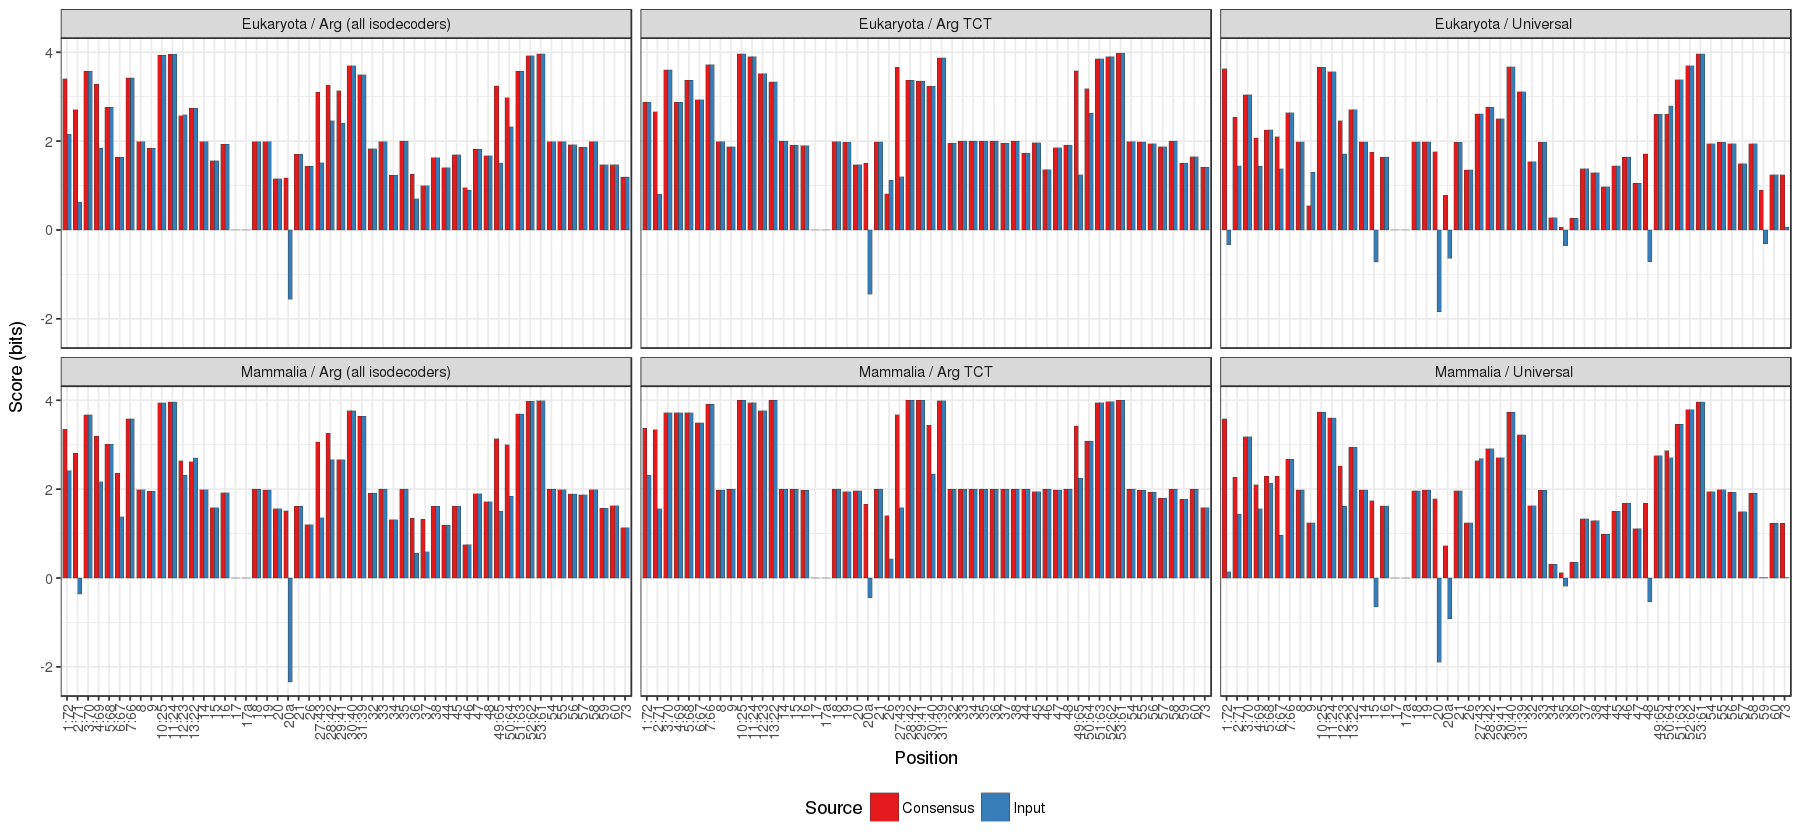

In [206]:
options(repr.plot.width=15, repr.plot.height=7)
ggplot(bits) + geom_bar(aes(x = Position, y = Bits, fill = Source), size = 0.1, color = 'gray20', width = 0.8, position = 'dodge', stat = 'identity') + 
  facet_wrap( ~ paste0(Clade, " / ", Isotype, " ", Anticodon)) + 
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position='bottom') + 
  scale_fill_manual(values = brewer.pal(3, "Set1")[1:2]) + 
  ylab("Score (bits)")

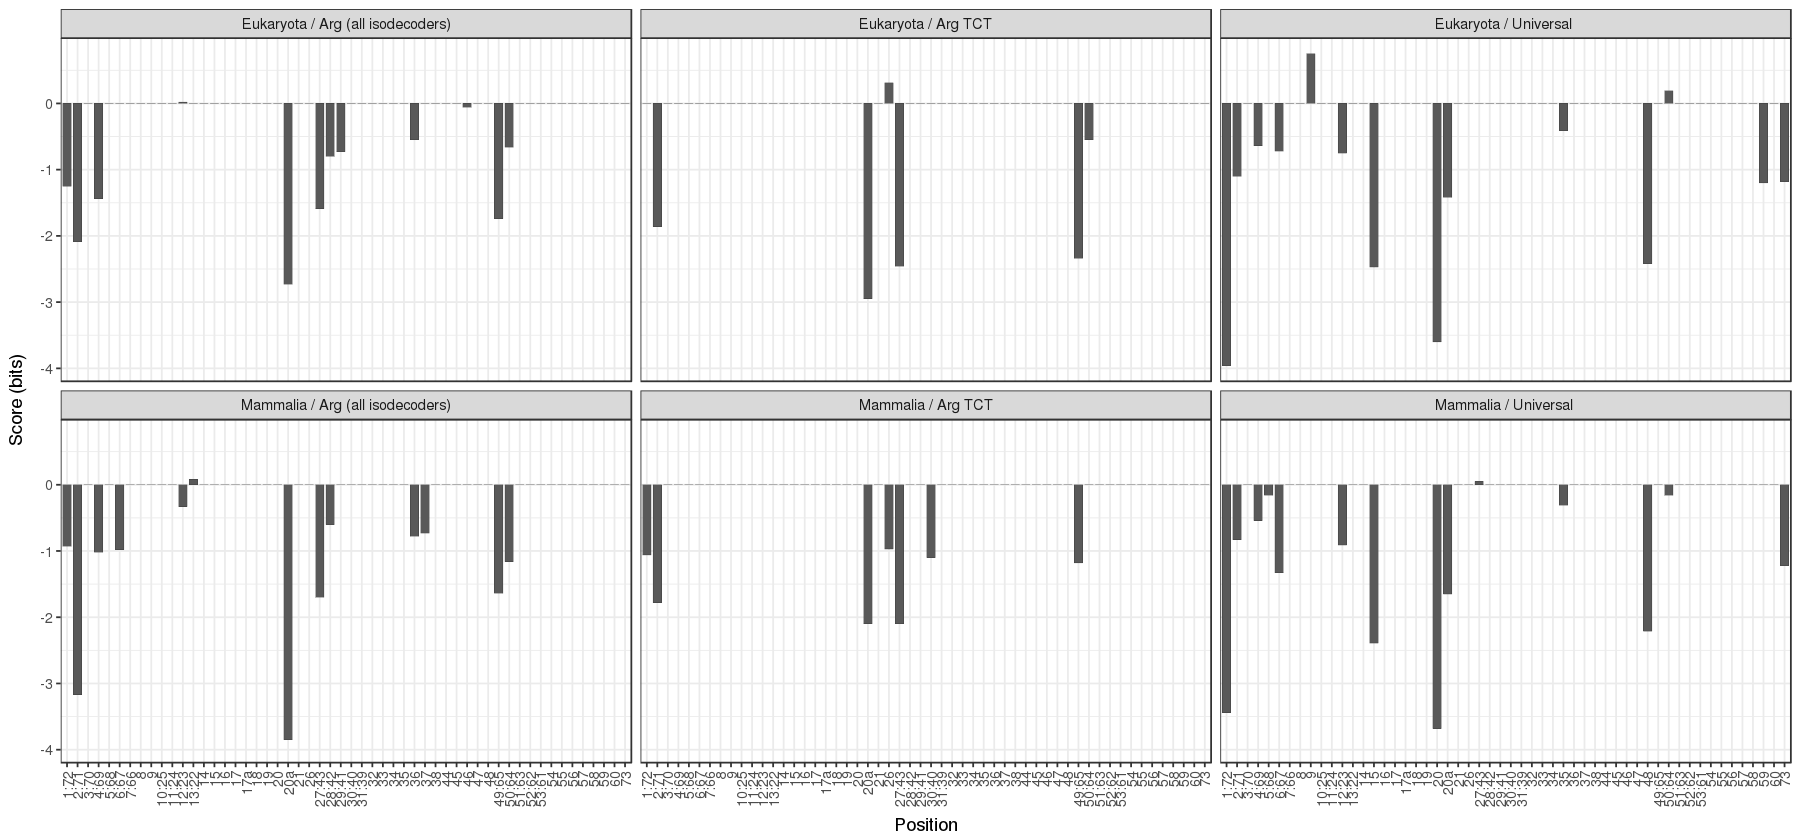

In [207]:
options(repr.plot.width=15, repr.plot.height=7)
bits %>% group_by(Position, Clade, Isotype, Anticodon) %>%
  arrange(Source) %>% 
  summarize(Bits = Bits[2] - Bits[1]) %>% 
  ggplot() + geom_bar(aes(x = Position, y = Bits), size = 0.1, color = 'gray20', width = 0.8, position = 'dodge', stat = 'identity') + 
    facet_wrap( ~ paste0(Clade, " / ", Isotype, " ", Anticodon)) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position='bottom') + 
    scale_fill_manual(values = brewer.pal(3, "Set1")[1:2]) + 
    ylab("Score (bits)")